=== 이벤트 이후 5거래일간 CAR (%) ===
한솔홈데코    -8.382620
대영포장    -21.140676
평화산업    -35.868520
평화홀딩스   -62.605101
dtype: float64


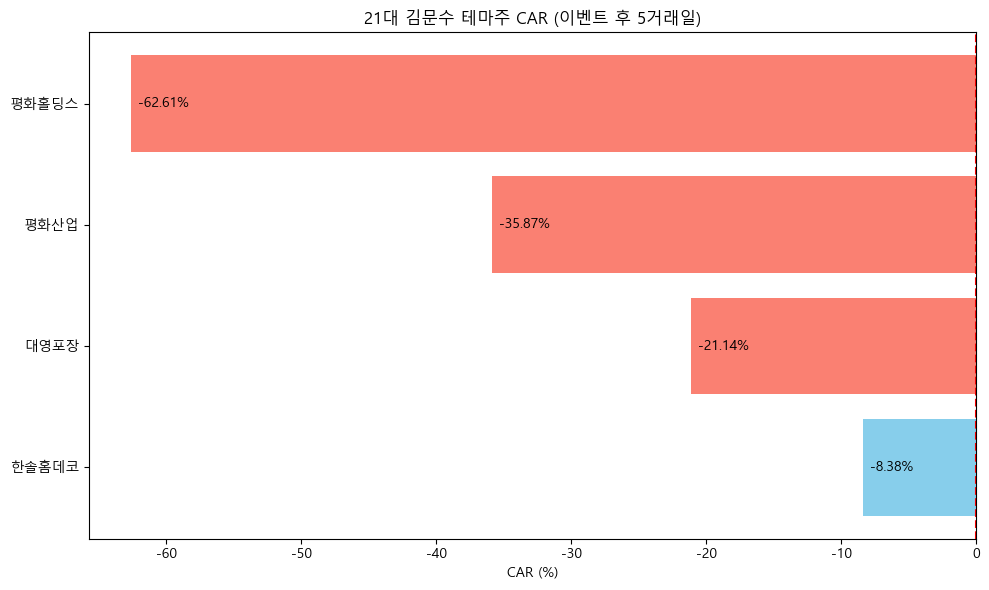

In [11]:
import FinanceDataReader as fdr
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl

# 시각화 설정
warnings.filterwarnings('ignore')
mpl.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 이벤트일 및 분석 설정
event_date = '2025-05-25'
event_dt = pd.to_datetime(event_date)
estimation_days = 250
car_days = 5
start_date = (event_dt - pd.Timedelta(days=estimation_days + 30)).strftime('%Y-%m-%d')
end_date = (event_dt + pd.Timedelta(days=car_days + 5)).strftime('%Y-%m-%d')

# 종목 설정
tickers = {
    '평화산업': '090080',
    '평화홀딩스': '010770',
    '대영포장': '014160',
    '한솔홈데코': '025750',
    'KODEX200':'069500'
}
# 데이터 다운로드
df = pd.DataFrame()
for name, code in tickers.items():
    df[name] = fdr.DataReader(code, start=start_date, end=end_date)['Close']
df.dropna(inplace=True)

# 로그수익률 계산
log_returns = np.log(df / df.shift(1)).dropna()
market_return = log_returns['KODEX200']

# 분석 구간 정의
estimation_data = log_returns[log_returns.index < event_dt].tail(estimation_days)
full_window_data = log_returns.loc[log_returns.index >= estimation_data.index[0]]

# 비정상수익률 및 CAR 계산
car_result = {}
abnormal_returns_dict = {}

for stock in tickers:
    if stock == 'KODEX200':
        continue

    y = estimation_data[stock]
    x = sm.add_constant(estimation_data['KODEX200'])
    model = sm.OLS(y, x).fit()

    x_full = sm.add_constant(full_window_data['KODEX200'])
    expected_full = model.predict(x_full)
    actual_full = full_window_data[stock]
    abnormal = actual_full - expected_full
    abnormal_returns_dict[stock] = abnormal
    car = abnormal.loc[abnormal.index > event_dt].head(car_days).sum() * 100
    car_result[stock] = car

# 시각화 1: 전체 CAR 막대그래프
car_series = pd.Series(car_result).sort_values(ascending=False)
print("=== 이벤트 이후 5거래일간 CAR (%) ===")
print(car_series)

colors = ['salmon' if abs(x) > 20 else 'skyblue' for x in car_series.values]

plt.figure(figsize=(10, 6))
bars = plt.barh(car_series.index, car_series.values, color=colors)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("21대 김문수 테마주 CAR (이벤트 후 5거래일)")
plt.xlabel("CAR (%)")

for bar in bars:
    width = bar.get_width()
    label_x = width - 0.5 if width > 0 else width + 0.5
    align = 'right' if width > 0 else 'left'
    plt.text(label_x, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}%', ha=align, va='center')

plt.tight_layout()
plt.show()


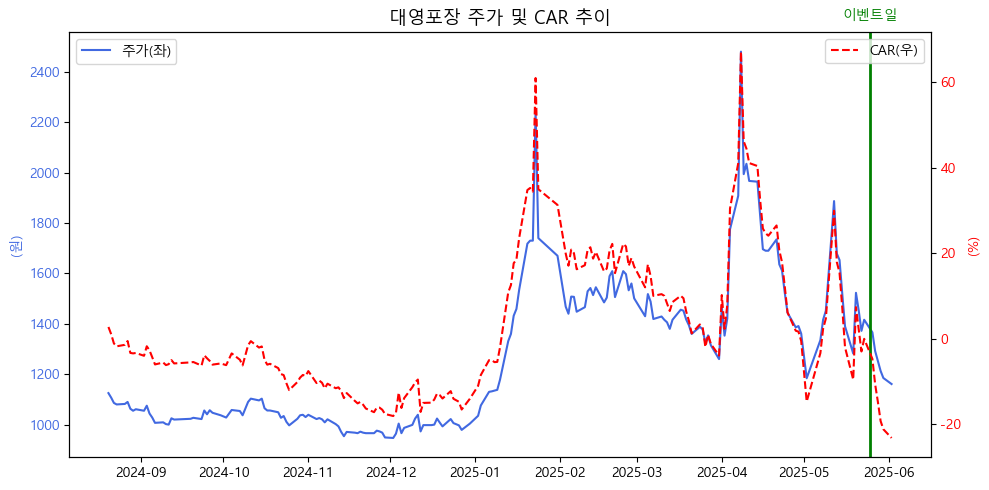

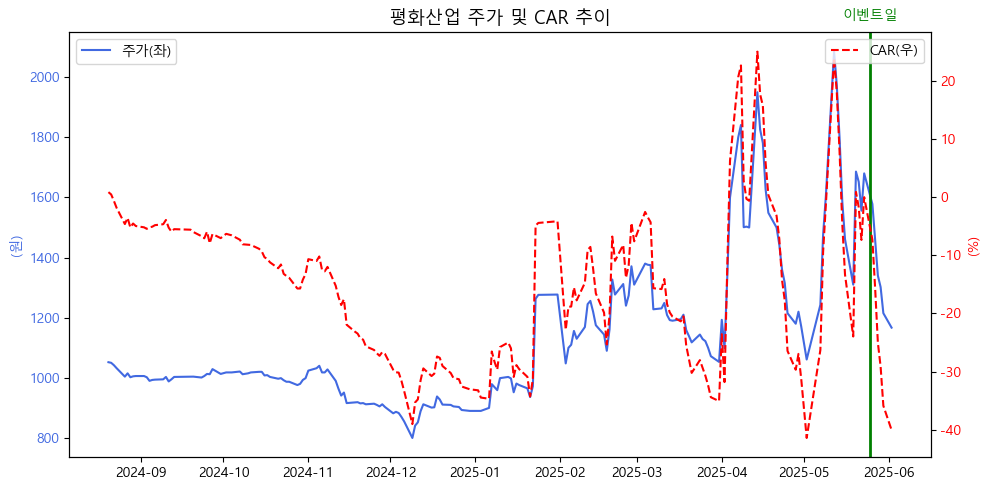

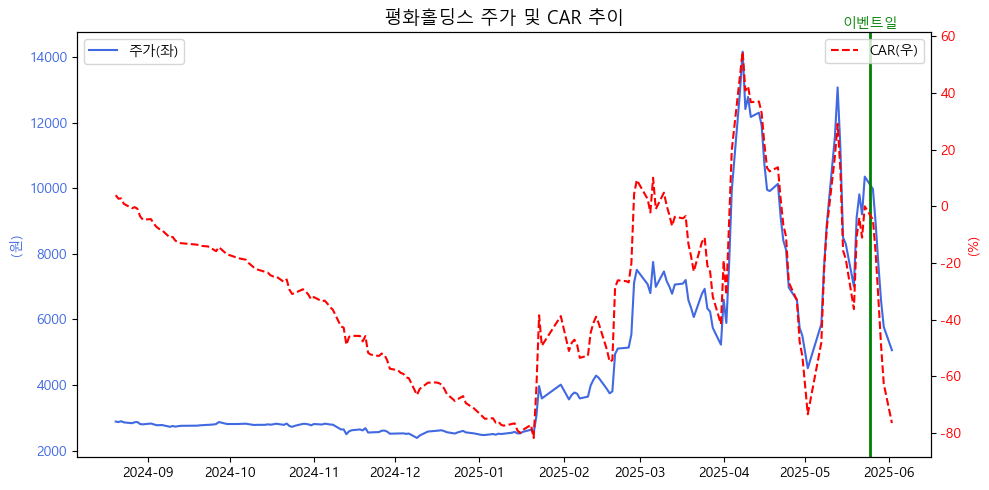

In [12]:
# 시각화 2: 절댓값 20% 넘는 종목들에 대한 개별 CAR 추이 그래프
selected = car_series[car_series.abs() > 20]

for stock in selected.index:
    abnormal_cumsum = abnormal_returns_dict[stock].cumsum() * 100
    price_series = df[stock][abnormal_cumsum.index]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()

    ax1.plot(price_series, color='royalblue', label='주가(좌)')
    ax1.set_ylabel('(원)', color='royalblue')
    ax1.tick_params(axis='y', labelcolor='royalblue')

    ax2.plot(abnormal_cumsum, color='red', linestyle='--', label='CAR(우)')
    ax2.set_ylabel('(%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # 이벤트일 세로선
    ax1.axvline(event_dt, color='green', linestyle='-', linewidth=2)
    ymax = price_series.max()
    ax1.annotate('이벤트일',
                 xy=(event_dt, ymax),
                 xytext=(event_dt, ymax * 1.05),
                 ha='center', color='green', fontsize=10)

    plt.title(f"{stock} 주가 및 CAR 추이", fontsize=13)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

